In [1]:
%matplotlib inline
from pandas_datareader import data
import pandas as pd
import random
from SALib.sample import latin
from functions.stylizedfacts import *
import scipy.stats as stats
from functions.evolutionaryalgo import *
from pandas_datareader import data
from functions.helpers import hurst, organise_data, div_by_hundred, discounted_value_cash_flow, find_horizon, calculate_npv
import matplotlib.pyplot as plt
import quandl
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import seaborn as sns

C:\Users\joerischasfoort\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Bootstrapped moments S&P 500
Following the procedure presented by [Franke & Westerhoff (2012)](https://www.sciencedirect.com/science/article/pii/S0165188912000802).

## 1 Get data

### a On returns 

In [2]:
start_date = '1993-03-10'
end_date = '2018-01-01'
window = 320

spy_nom_price = data.DataReader("SPY", 
                       start=start_date, 
                       end=end_date, 
                       data_source='yahoo')['Close']
spy_nom_returns = spy_nom_price.pct_change()[1:]

spy_real_price = quandl.get("MULTPL/SP500_REAL_PRICE_MONTH", authtoken="8EKNms1cLLU-dBjk5Y4d").loc[start_date:end_date]
spy_real_price = quandl.get("MULTPL/SP500_REAL_PRICE_MONTH", authtoken="8EKNms1cLLU-dBjk5Y4d").loc[start_date:end_date]
spy_real_price = spy_real_price.rename(columns={"Value": "price"})

spy_returns = spy_real_price.pct_change()[1:]

spy_dividends = quandl.get("BUNDESBANK/BBQFS_M_US_CORP_PRICE_SP500__X_0000", authtoken="8EKNms1cLLU-dBjk5Y4d").loc[start_date:end_date]
spy_dividends = spy_dividends.rename(columns={"Value": "dividends"})
spy_dividends.index = spy_dividends.index + pd.offsets.MonthBegin(1)
spy_all = spy_dividends.join(spy_real_price)

spy_t_bill = quandl.get("FRED/INTGSTUSM193N", authtoken="8EKNms1cLLU-dBjk5Y4d").loc[start_date:end_date]
spy_t_bill = spy_t_bill.rename(columns={"Value": "dividends"})

spy_all['t_bill_int'] = spy_t_bill / 100

spy_all['div_growth'] = spy_all['dividends'].pct_change()
spy_all['av_div_growth'] = spy_all['div_growth'].rolling(window=window,center=False).mean()
spy_all['yield'] = spy_all['dividends'].iloc[1:] / spy_all['price'].iloc[:-1]
spy_all['ml_discount'] = [0.052 for x in range(len(spy_all))]
spy_all['fixed_yield'] = spy_all['t_bill_int'] + spy_all['ml_discount']

#spy_all = spy_all.iloc[-window:-1]

spy_all['fundamental'] = ((1 + spy_all['av_div_growth']) / (spy_all['fixed_yield'] - spy_all['av_div_growth'])) * spy_all['dividends']
spy_all['dev_fundamental'] = (spy_all['price'] - spy_all['fundamental']) / spy_all['fundamental']

### b On fundamentals

In [3]:
shiller_data = pd.read_excel('http://www.econ.yale.edu/~shiller/data/ie_data.xls', header=7)[:-3]

In [4]:
schul_data = pd.read_excel('http://www.macrohistory.net/JST/JSTmoneyR3.xlsx', sheetname='Data')[['year', 'country', 'stir']]
schul_data = schul_data.loc[(schul_data.country == 'USA')]
schul_data = schul_data.iloc[1:]
schul_data = schul_data.set_index('year')

Extend Schularick annual data to monthly data. 

In [5]:
schul_data['stir']

short_term_int = []
counter = -1
for idx in range(len(shiller_data)):
    if idx % 12 == 0:
        counter += 1
    try:
        short_term_int.append(schul_data['stir'].iloc[counter])
    except:
        pass

In [6]:
discount_rates = np.array(short_term_int) + 5.2 # Discount rate = short-term interest rate + discount rate as estimated by
discount_rates = pd.Series(discount_rates).apply(div_by_hundred)

In [7]:
long_int = shiller_data['Rate GS10'].apply(div_by_hundred)
current_index = 0
final_index = len(shiller_data['Dividend'])
discounted_cash_flows = shiller_data['Dividend'] / ((1 + long_int)**range(current_index, final_index))

Calculate the fundamental value

In [8]:
fundamental_values = []
for idx, cf in enumerate(shiller_data['Dividend'][:-18]):
    next_period_divs = shiller_data['Dividend'][idx+1:]
    next_period_ints = discount_rates[idx+1]
    npv = calculate_npv(next_period_divs, next_period_ints)
    if not np.isnan(npv):
        fundamental_values.append(npv)
    else:
        break

In [9]:
real_prices = shiller_data['Price'][:len(fundamental_values)]

Calculate co-integration of market price with fundamentals.

In [10]:
def cointegr(fundament, price):
    """
    Calculate cointegration with fundamentals
    Return ADF test statistic, ADF critical values 
    """
    model = sm.OLS(fundament, price)
    res = model.fit()
    residuals = res.resid
    cadf = ts.adfuller(residuals)
    return cadf[0], cadf[4]

In [11]:
cointegr(fundamental_values, real_prices)

(-3.3959329470058419,
 {'1%': -3.4343955209592241,
  '10%': -2.5677212878453477,
  '5%': -2.8633268625511046})

In [12]:
model = sm.OLS(fundamental_values, shiller_data['Price'][:len(fundamental_values)])
res = model.fit()
residuals = res.resid

In [13]:
cadf = ts.adfuller(residuals) # can be rejected at 5%
print('ADF test statistic ', cadf[0])
print('ADF critical values', cadf[4])

ADF test statistic  -3.39593294701
ADF critical values {'1%': -3.4343955209592241, '5%': -2.8633268625511046, '10%': -2.5677212878453477}


In [14]:
ts.adfuller(residuals[:800])[0]

-3.2114596209358188

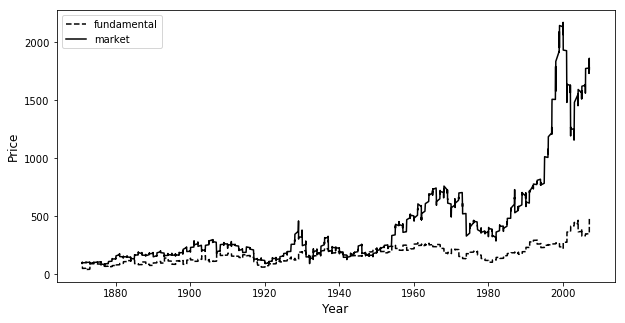

In [15]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

time=0

ax1.plot(shiller_data['Date'][time:len(fundamental_values)], fundamental_values[time:], 'k--', label='fundamental')
ax1.plot(shiller_data['Date'][time:len(fundamental_values)], shiller_data['Price'][time:len(fundamental_values)], 'k-', label='market')

ax1.set_ylabel('Price', fontsize='12')
ax1.set_xlabel('Year', fontsize='12')

ax1.legend()

## 2 Bootstrap data in three blocks

In [17]:
small_block_size = 250
large_block_size = 750
shiller_block_size = 205

**Small data blocks returns**
For short term moments, I produce a bootstrapped series of 250 day (= 1 year) data blocks. This means that there are 25 unique blocks. 

In [18]:
small_data_blocks = []
for x in range(0, len(spy_nom_returns), small_block_size):
    small_data_blocks.append(list(spy_nom_returns[x:x+small_block_size]))
    
# draw 5000 random series
bootstrapped_small_series = []
for i in range(5000):
    sim_data = [random.choice(small_data_blocks) for _ in small_data_blocks]
    sim_data2 = [j for i in sim_data for j in i]
    bootstrapped_small_series.append(sim_data2)

**Large data blocks returns**

For the longer moments, I produce a bootstrapped series of data blocks of 750 days. To accomodate this, I cut the data set with 250 observations, to 6000 observations. 

In [19]:
large_data_blocks = []
for x in range(0, len(spy_nom_returns[:-250]), large_block_size):
    large_data_blocks.append(list(spy_nom_returns[x:x+large_block_size]))
    
# draw 5000 random series
bootstrapped_long_series = []
for i in range(5000):
    sim_data = [random.choice(large_data_blocks) for _ in large_data_blocks]
    sim_data2 = [j for i in sim_data for j in i]
    bootstrapped_long_series.append(sim_data2)

**Fundamentals data blocks**

For the deviation from fundamentals, I bootstrap the returns of both the fundamental value and the associated returns for market prices. I divided these into blocks. Then, I bootstrap these blocks of returns into new time series and apply them to the starting values of the fundamental value and real prices. This results in 5000 hypothetical time series of fundamentals and real prices. 

In [20]:
# calculate returns for both
fundamental_returns = pd.Series(fundamental_values).pct_change()[1:]
real_prices_returns = pd.Series(real_prices).pct_change()[1:]

In [21]:
def hypothetical_series(starting_value, returns):
    """
    input: starting_value: float starting value
    input: returns: list 
    """
    returns = list(returns)
    simulated_series = [starting_value]
    for idx in range(len(returns)):
        simulated_series.append(simulated_series[-1] * (1 + returns[idx]))
    return simulated_series

In [22]:
# divide both fundamental returns and price returns into blocks
shiller_data_blocks = []
for x in range(0, len(fundamental_returns[:-3]), shiller_block_size):
    shiller_data_blocks.append((list(fundamental_returns[x:x+shiller_block_size]), list(real_prices_returns[x:x+shiller_block_size])))

In [35]:
# draw 5000 random series 
bootstrapped_shiller_series = []
for i in range(5000):
    #print(i)
    # first sample the data
    sim_data = [random.choice(shiller_data_blocks) for _ in shiller_data_blocks] # choose a random set of blocks
    sim_data_fundamental_returns = [pair[0] for pair in sim_data]
    sim_data_price_returns = [pair[1] for pair in sim_data]
    
    # merge the list of lists
    sim_data_fundamental_returns1 = [item for sublist in sim_data_fundamental_returns for item in sublist]
    sim_data_price_returns1 = [item for sublist in sim_data_price_returns for item in sublist]
    
    # calculate the new time_series
    sim_data_fundamentals = hypothetical_series(fundamental_values[0], sim_data_fundamental_returns1)
    sim_data_prices = hypothetical_series(real_prices[0], sim_data_price_returns1)
    
    bootstrapped_shiller_series.append((sim_data_fundamentals, sim_data_prices))

## 3 Choose moments

For returns, I use the following moments **short-term moments**: 

1. mean first-order autocorrelation of the raw returns (no predictability),
2. autocorrelations at lags t ¼ 1
3. autocorrelations at lags t ¼ 5
4. mean first-order autocorrelation of the of the absolute returns (volatility clustering),
5. Kurtosis (fat tails), 

In [27]:
first_order_autocors = []
mean_abs_autocor = []
autocors1 = []
autocors5 = []
kurtoses = []
for rets in bootstrapped_small_series:
    first_order_autocors.append(autocorrelation_returns(rets, 25))
    mean_abs_autocor.append(autocorrelation_abs_returns(rets, 25))
    rets = pd.Series(rets)
    autocors1.append(rets.autocorr(lag=1))
    autocors5.append(rets.autocorr(lag=5))
    kurtoses.append(kurtosis(rets))

For long-term moments, I use the autocorrelation of returns for the with lags (10, 25, 50, 100).

In [28]:
spy_abs_auto10 = []
spy_abs_auto25 = []
spy_abs_auto50 = []
spy_abs_auto100 = []

for rets in bootstrapped_long_series:
    rets = pd.Series(rets)
    spy_abs_auto10.append(rets.abs().autocorr(lag=10))
    spy_abs_auto25.append(rets.abs().autocorr(lag=25))
    spy_abs_auto50.append(rets.abs().autocorr(lag=50))
    spy_abs_auto100.append(rets.abs().autocorr(lag=100))

For deviations from fundamentals, I use the AFD t-score to test for mean-reversion in the relationship between fundamentals and the price.

In [37]:
cointegrations = []

for sers in bootstrapped_shiller_series:
    cointegrations.append(cointegr(sers[0], sers[1])[0])

## Plot data

In [38]:
# Get the t-critical value*
def confidence_interval(sample):
    """Calculate confidence_interval in sample"""
    z_critical = stats.norm.ppf(q = 0.99)
    mean = np.mean(sample)
    stdev = np.std(sample)
    margin_of_error = z_critical * stdev
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)  
    return confidence_interval

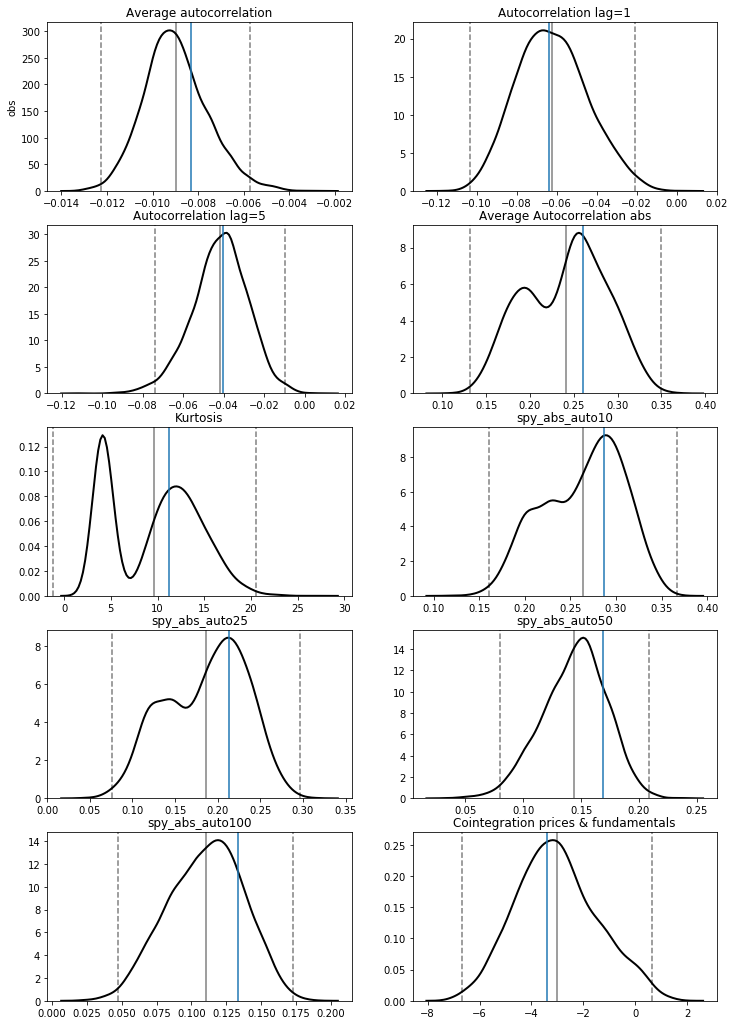

In [50]:
fig, ((ax1, ax2), (ax3, ax4) , (ax5, ax6) , (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(12,18))

# 1 mean autocor
sns.distplot(first_order_autocors, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax1)

for xc in confidence_interval(first_order_autocors):
    ax1.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax1.axvline(x=np.mean(first_order_autocors), color='k', alpha=0.5)
ax1.axvline(x=autocorrelation_returns(spy_nom_returns, 25))

ax1.set_ylabel('obs')
ax1.set_title('Average autocorrelation')

# 2 autocorr lag 1 
sns.distplot(autocors1, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax2)
ax2.set_title('Autocorrelation lag=1')

for xc in confidence_interval(autocors1):
    ax2.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax2.axvline(x=np.mean(autocors1), color='k', alpha=0.5)
ax2.axvline(x=spy_nom_returns.autocorr(lag=1))

# 3 autocorr lag 1 
sns.distplot(autocors5, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax3)
ax3.set_title('Autocorrelation lag=5')

for xc in confidence_interval(autocors5):
    ax3.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax3.axvline(x=np.mean(autocors5), color='k', alpha=0.5)
ax3.axvline(x=spy_nom_returns.autocorr(lag=5))

# 4 mean abs autocor
sns.distplot(mean_abs_autocor, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax4)

for xc in confidence_interval(mean_abs_autocor):
    ax4.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax4.axvline(x=np.mean(mean_abs_autocor), color='k', alpha=0.5)
ax4.axvline(x=autocorrelation_abs_returns(spy_nom_returns, 25))

ax4.set_title('Average Autocorrelation abs')

# 5 kurtosis
sns.distplot(kurtoses, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax5)

for xc in confidence_interval(kurtoses):
    ax5.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax5.axvline(x=np.mean(kurtoses), color='k', alpha=0.5)
ax5.axvline(x=kurtosis(spy_nom_returns))

ax5.set_title('Kurtosis')

# 6 AC abs long 10
sns.distplot(spy_abs_auto10, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax6)

for xc in confidence_interval(spy_abs_auto10):
    ax6.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax6.axvline(x=np.mean(spy_abs_auto10), color='k', alpha=0.5)
ax6.axvline(x=spy_nom_returns.abs().autocorr(lag=10))

ax6.set_title('spy_abs_auto10')

# 7 AC abs long 25
sns.distplot(spy_abs_auto25, hist=False, kde=True, color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax7)

for xc in confidence_interval(spy_abs_auto25):
    ax7.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax7.axvline(x=np.mean(spy_abs_auto25), color='k', alpha=0.5)
ax7.axvline(x=spy_nom_returns.abs().autocorr(lag=25))

ax7.set_title('spy_abs_auto25')

# 8 AC abs long 50
sns.distplot(spy_abs_auto50, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax8)

for xc in confidence_interval(spy_abs_auto50):
    ax8.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax8.axvline(x=np.mean(spy_abs_auto50), color='k', alpha=0.5)
ax8.axvline(x=spy_nom_returns.abs().autocorr(lag=50))

ax8.set_title('spy_abs_auto50')

# 9 AC abs long 100
sns.distplot(spy_abs_auto100, hist=False, kde=True, color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax9)

for xc in confidence_interval(spy_abs_auto100):
    ax9.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax9.axvline(x=np.mean(spy_abs_auto100), color='k', alpha=0.5)
ax9.axvline(x=spy_nom_returns.abs().autocorr(lag=100))

ax9.set_title('spy_abs_auto100')

# 10 Deviation from fundamentals
sns.distplot(cointegrations, hist=False, kde=True, color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax10)

for xc in confidence_interval(cointegrations):
    ax10.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax10.axvline(x=np.mean(cointegrations), color='k', alpha=0.5)
ax10.axvline(x=cointegr(fundamental_values, real_prices)[0])

ax10.set_title('Cointegration prices & fundamentals')

fig.savefig('moments.png')

### Covariance matrix between moments:

1. Make an estimate of the long-run covariance matrix Ω̂ of the empirical moments
2. $Ω_{sT}$ is a kernel-weighted average of these matrices, truncated at a suitable lag p. Using the Bartlett kernel with its linearly declining weights gives us the popular Newey–West estimator,
3. The weighting matrix is then the inverse of this matrix

In [57]:
# contruct matrix with: row = variables, column = observations
simulated_moments = np.array([first_order_autocors, autocors1, autocors5, mean_abs_autocor, kurtoses,
                              spy_abs_auto10, spy_abs_auto25, spy_abs_auto50, spy_abs_auto100, cointegrations])

In [73]:
var_cov_matrix = pd.DataFrame(simulated_moments).transpose().cov().as_matrix()
pd.DataFrame(np.linalg.inv(var_cov_matrix))

,0,1,2,3,4,5,6,7,8,9
0,563755.251321,-11136.090287,6885.482509,-856.133120,22.686718,809.427257,-883.065523,-420.592767,631.642366,3.103906
1,-11136.090287,7204.584136,-1492.063561,622.037605,12.588772,-300.182453,247.523244,4.339993,16.880208,-0.286495
2,6885.482509,-1492.063561,5687.339256,-377.804799,1.638469,-269.474797,295.814263,-58.700093,-52.769222,-0.403347
3,-856.133120,622.037605,-377.804799,2245.807373,-18.519848,174.686130,-187.781651,-56.896871,84.074973,-0.134827
4,22.686718,12.588772,1.638469,-18.519848,0.247059,-2.662788,2.332397,0.557769,-0.384918,0.000448
5,809.427257,-300.182453,-269.474797,174.686130,-2.662788,18905.480600,-18364.277619,-4099.449189,6081.267281,1.026290
6,-883.065523,247.523244,295.814263,-187.781651,2.332397,-18364.277619,19624.437961,3466.757245,-8178.162316,-0.650213
7,-420.592767,4.339993,-58.700093,-56.896871,0.557769,-4099.449189,3466.757245,5673.508198,-4701.320625,0.369154
8,631.642366,16.880208,-52.769222,84.074973,-0.384918,6081.267281,-8178.162316,-4701.320625,9742.308303,-1.164310
9,3.103906,-0.286495,-0.403347,-0.134827,0.000448,1.026290,-0.650213,0.369154,-1.164310,0.403452


# Next step: calibrate to moments

The traditional approach for the method of simulated moments is to calibrate the model to the empirical moments by minimizing a quadtratic loss function: 

$J = J(m) = (m^{sim} - m^{emp})' W (m^{sim} - m^{emp}) $

The first term is the transpose of the difference between simulated and actual moments. The seond term is the weighting matrix. The third term is the difference between simulated and empirical moments. 

which represents the distance between the simulated and empirical moments.

To reduce the sample variability in the stochastic simulations, I choose a time horizon (following [Franke & Westerhoff (2012)](https://www.sciencedirect.com/science/article/pii/S0165188912000802)) of 10 times the empirical time series. In this case the longest time series. 



In [54]:
simulation_time = max(len(spy_nom_returns), len(fundamental_values)) * 10
simulation_time

62500